# 207 final project
### dataset: child mind institute - problematic internet use
### kaggle: https://www.kaggle.com/competitions/child-mind-institute-problematic-internet-use/overview

In [1]:
# import necessary libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import History
import warnings

# suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
# load data
df = pd.read_csv("~/mids/207/final project/train.csv")
df.head()

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# data preprocessing

# verify the filtering
print(f"Number of rows before filtering: {len(df)}")

# filter df to age >= 8 or < 8
df = df[df['Basic_Demos-Age'] >= 8]

# reset the index
df.reset_index(drop=True, inplace=True)

# verify the filtering
print(f"Number of rows after filtering: {len(df)}")

# drop rows with null target
df = df.dropna(subset=["sii"])

# exclude PCIAT variables
pciat_cols = [col for col in df.columns if "PCIAT" in col]
df = df.drop(columns=pciat_cols)

# handle missing values
for col in df.columns:
    if df[col].dtype == "object":
        df[col].fillna("missing", inplace=True)
    else:
        df[col].fillna(0, inplace=True)

# encode categorical features
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for column in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print(f"\nValue counts of target variable:\n{df['sii'].value_counts()}")
    
# convert to binary classification
df['sii'] = df['sii'].apply(lambda x: 0 if x == 0 else 1)
print("\nConverting to binary class ...")
print(f"\nValue counts of target variable:\n{df['sii'].value_counts()}")
  
# split data
target = "sii"
features = df.drop(columns=[target])
X_train, X_temp, y_train, y_temp = train_test_split(features, df[target], test_size=0.4, random_state=33)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)
# add stratify

Number of rows before filtering: 3960
Number of rows after filtering: 3043

Value counts of target variable:
0.0    1067
1.0     628
2.0     348
3.0      34
Name: sii, dtype: int64

Converting to binary class ...

Value counts of target variable:
0    1067
1    1010
Name: sii, dtype: int64


In [4]:
# feature selection

# identify numeric features
numeric_cols = features.select_dtypes(include=["float64", "int64"]).columns

# standardize data
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# apply selectkbest feature selection after standardization
k = 20
selector = SelectKBest(score_func=mutual_info_classif, k=k)
X_train_selected = selector.fit_transform(X_train, y_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

# retrieve feature scores and names
feature_scores = selector.scores_  
feature_names = X_train.columns

# combine and sort scores
feature_scores_df = pd.DataFrame({
    "Feature": feature_names,
    "Score": feature_scores
}).sort_values(by="Score", ascending=False)

# print top features
print(f"\nTop {k} Features Using SelectKBest:")
print(feature_scores_df.head(k))

selected_features = features.columns[selector.get_support()]
dropped_features = features.columns[~selector.get_support()]
print(f"\nSelected Features ({k}): {list(selected_features)}")
print(f"\nDropped Features ({len(list(dropped_features))}): {list(dropped_features)}")


Top 20 Features Using SelectKBest:
                                   Feature     Score
2                          Basic_Demos-Age  0.051299
8                          Physical-Height  0.041936
22                       FGC-FGC_GSND_Zone  0.039270
46                             BIA-BIA_LDM  0.039065
48                             BIA-BIA_SMM  0.038634
47                             BIA-BIA_LST  0.035743
39                             BIA-BIA_ECW  0.032575
9                          Physical-Weight  0.029652
49                             BIA-BIA_TBW  0.029317
27                             FGC-FGC_SRL  0.027003
43                             BIA-BIA_Fat  0.026434
56                         SDS-SDS_Total_T  0.025815
45                             BIA-BIA_ICW  0.025024
58  PreInt_EduHx-computerinternet_hoursday  0.024943
53                       PAQ_C-PAQ_C_Total  0.022638
38                             BIA-BIA_DEE  0.022040
7                             Physical-BMI  0.021202
21        


Confusion Matrix: Majority Baseline


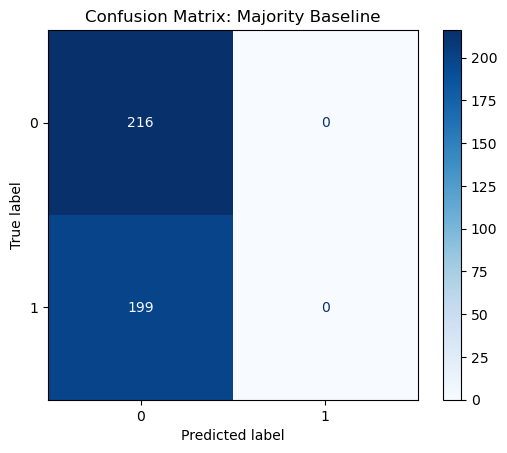

In [5]:
# majority baseline classifier
majority_class = y_train.mode()[0]
y_pred_majority = np.full_like(y_val, fill_value=majority_class)

# binarize the target for ROC AUC
classes = np.unique(y_train)
y_train_binarized = label_binarize(y_train, classes=classes)
y_val_binarized = label_binarize(y_val, classes=classes)
roc_auc_majority = roc_auc_score(y_val_binarized, label_binarize(y_pred_majority, classes=classes), multi_class="ovr")

f1_majority = classification_report(y_val, y_pred_majority, output_dict=True)['weighted avg']['f1-score']
train_accuracy = accuracy_score(y_train, np.full_like(y_train, fill_value=majority_class))
val_accuracy = accuracy_score(y_val, y_pred_majority)

baseline_summary = {
    "Model": "Majority Baseline",
    "Train Accuracy": train_accuracy,
    "Val Accuracy": val_accuracy,
    "Train F1": f1_majority,  
    "Val F1": f1_majority,   
    "ROC AUC": roc_auc_majority,
    "Train Time (s)": 0, 
}

# confusion matrix for majority baseline
print("\nConfusion Matrix: Majority Baseline")
cm_majority = confusion_matrix(y_val, y_pred_majority)
disp_majority = ConfusionMatrixDisplay(confusion_matrix=cm_majority, display_labels=classes)
disp_majority.plot(cmap="Blues")
plt.title("Confusion Matrix: Majority Baseline")
plt.show()

print("================================================================")


Training Logistic Regression...

Best Parameters: {'C': 0.1, 'penalty': 'l2'}
Train Accuracy: 0.6685393258426966
Val Accuracy: 0.6674698795180722
Train F1-Score: 0.668254392276269
Val F1-Score: 0.6675703791592649
ROC AUC (OvR): 0.7144286246045041

              precision    recall  f1-score   support

           0       0.68      0.67      0.68       216
           1       0.65      0.66      0.66       199

    accuracy                           0.67       415
   macro avg       0.67      0.67      0.67       415
weighted avg       0.67      0.67      0.67       415



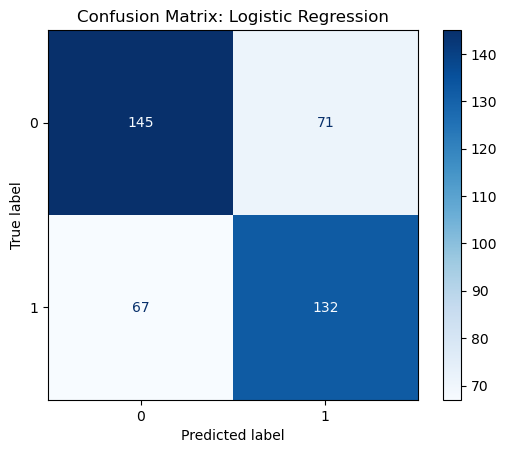


Training Random Forest...

Best Parameters: {'max_depth': 5, 'n_estimators': 200}
Train Accuracy: 0.7536115569823435
Val Accuracy: 0.6602409638554216
Train F1-Score: 0.7535815606116547
Val F1-Score: 0.660323914285396
ROC AUC (OvR): 0.7045644891122278

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       216
           1       0.64      0.65      0.65       199

    accuracy                           0.66       415
   macro avg       0.66      0.66      0.66       415
weighted avg       0.66      0.66      0.66       415



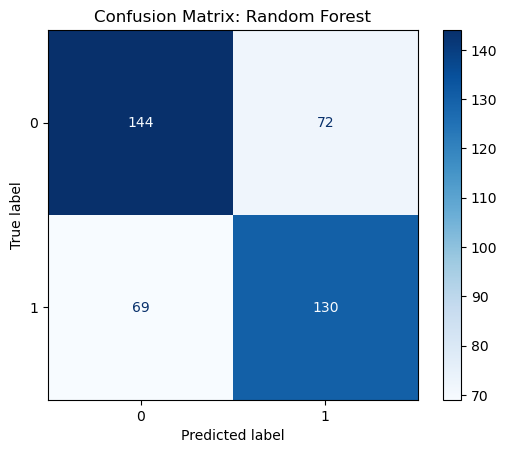


Training Gradient Boosting...

Best Parameters: {'learning_rate': 0.2, 'n_estimators': 50}
Train Accuracy: 0.8443017656500803
Val Accuracy: 0.6433734939759036
Train F1-Score: 0.84428571548534
Val F1-Score: 0.6434812761997915
ROC AUC (OvR): 0.6976200446677834

              precision    recall  f1-score   support

           0       0.66      0.65      0.65       216
           1       0.63      0.64      0.63       199

    accuracy                           0.64       415
   macro avg       0.64      0.64      0.64       415
weighted avg       0.64      0.64      0.64       415



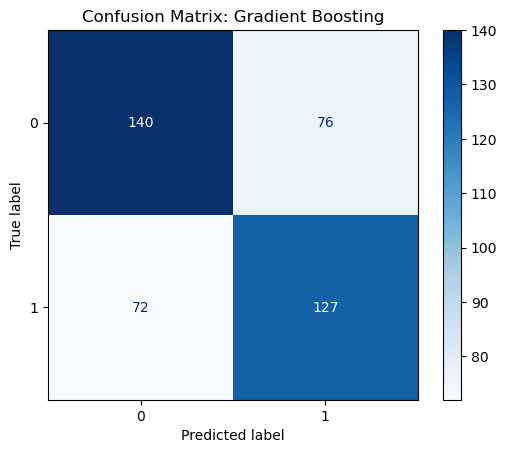

In [6]:
# additional model types

# dictionary to store ROC data for each model
roc_data = {}

# models with hyperparameter tuning
models_with_params = {
    "Logistic Regression": (LogisticRegression(solver="liblinear", multi_class="ovr", max_iter=500), {
        "penalty": ["l2"],
        "C": [0.1, 1, 10],
    }),
    "Random Forest": (RandomForestClassifier(random_state=33), {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [5, 10, 20],
    }),
    "Gradient Boosting": (GradientBoostingClassifier(random_state=33), {
        "n_estimators": [50, 100, 200, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.2],
    }),
}

# store results for summary
summary_results = [baseline_summary]

for name, (model, param_grid) in models_with_params.items():
    print(f"\nTraining {name}...\n")
    start_time = time.time()

    # hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring="roc_auc_ovr", n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)

    duration = time.time() - start_time
    best_model = grid_search.best_estimator_

    # validation predictions
    y_pred_train = best_model.predict(X_train_selected)
    y_pred_val = best_model.predict(X_val_selected)
    y_prob_val = best_model.predict_proba(X_val_selected)

    # metrics
    train_f1 = f1_score(y_train, y_pred_train, average="weighted")
    val_f1 = f1_score(y_val, y_pred_val, average="weighted")
    roc_auc = roc_auc_score(y_val, y_prob_val[:, 1])
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train)}")
    print(f"Val Accuracy: {accuracy_score(y_val, y_pred_val)}")
    print(f"Train F1-Score: {train_f1}")
    print(f"Val F1-Score: {val_f1}")
    print(f"ROC AUC (OvR): {roc_auc}\n")
    print(classification_report(y_val, y_pred_val))

    # record results
    summary_results.append({
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_pred_train),
        "Val Accuracy": accuracy_score(y_val, y_pred_val),
        "Train F1": train_f1,
        "Val F1": val_f1,
        "ROC AUC": roc_auc,
        "Train Time (s)": duration,
    })

    # confusion matrix
    cm = confusion_matrix(y_val, y_pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()
  
    print("================================================================")


Training FF Neural Network...
Epoch 1/100


2024-12-02 20:29:22.688210: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-12-02 20:29:22.688239: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-02 20:29:22.688251: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-02 20:29:22.688273: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-02 20:29:22.688287: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-12-02 20:29:23.029985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


78/78 - 2s - 24ms/step - accuracy: 0.4928 - loss: 0.7793 - val_accuracy: 0.5036 - val_loss: 0.7001
Epoch 2/100
78/78 - 1s - 8ms/step - accuracy: 0.5193 - loss: 0.7341 - val_accuracy: 0.5759 - val_loss: 0.6872
Epoch 3/100
78/78 - 1s - 8ms/step - accuracy: 0.5474 - loss: 0.7099 - val_accuracy: 0.5928 - val_loss: 0.6811
Epoch 4/100
78/78 - 1s - 8ms/step - accuracy: 0.5498 - loss: 0.6952 - val_accuracy: 0.6024 - val_loss: 0.6758
Epoch 5/100
78/78 - 1s - 8ms/step - accuracy: 0.5762 - loss: 0.6827 - val_accuracy: 0.6169 - val_loss: 0.6707
Epoch 6/100
78/78 - 1s - 8ms/step - accuracy: 0.5770 - loss: 0.6845 - val_accuracy: 0.6072 - val_loss: 0.6662
Epoch 7/100
78/78 - 1s - 8ms/step - accuracy: 0.5875 - loss: 0.6761 - val_accuracy: 0.6000 - val_loss: 0.6617
Epoch 8/100
78/78 - 1s - 8ms/step - accuracy: 0.5770 - loss: 0.6753 - val_accuracy: 0.6361 - val_loss: 0.6605
Epoch 9/100
78/78 - 1s - 8ms/step - accuracy: 0.6132 - loss: 0.6587 - val_accuracy: 0.6386 - val_loss: 0.6593
Epoch 10/100
78/78 - 

Epoch 75/100
78/78 - 1s - 8ms/step - accuracy: 0.6421 - loss: 0.6259 - val_accuracy: 0.6651 - val_loss: 0.6227
Epoch 76/100
78/78 - 1s - 8ms/step - accuracy: 0.6557 - loss: 0.6264 - val_accuracy: 0.6723 - val_loss: 0.6239
Epoch 77/100
78/78 - 1s - 8ms/step - accuracy: 0.6653 - loss: 0.6294 - val_accuracy: 0.6723 - val_loss: 0.6260
Epoch 78/100
78/78 - 1s - 8ms/step - accuracy: 0.6461 - loss: 0.6249 - val_accuracy: 0.6723 - val_loss: 0.6261
Epoch 79/100
78/78 - 1s - 8ms/step - accuracy: 0.6597 - loss: 0.6238 - val_accuracy: 0.6675 - val_loss: 0.6236
Epoch 80/100
78/78 - 1s - 8ms/step - accuracy: 0.6637 - loss: 0.6257 - val_accuracy: 0.6723 - val_loss: 0.6243
Epoch 81/100
78/78 - 1s - 8ms/step - accuracy: 0.6581 - loss: 0.6148 - val_accuracy: 0.6699 - val_loss: 0.6233
Epoch 82/100
78/78 - 1s - 8ms/step - accuracy: 0.6517 - loss: 0.6232 - val_accuracy: 0.6723 - val_loss: 0.6233
Epoch 83/100
78/78 - 1s - 8ms/step - accuracy: 0.6629 - loss: 0.6271 - val_accuracy: 0.6723 - val_loss: 0.6223
E

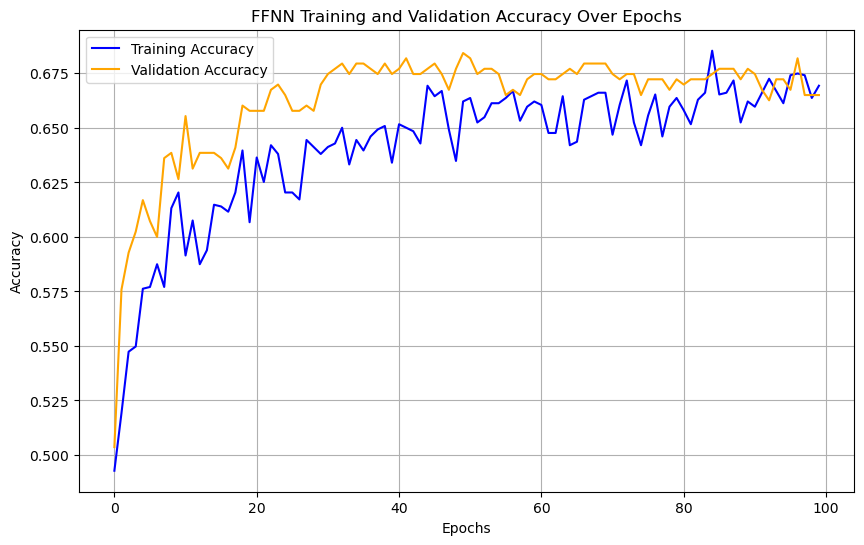

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step

Training Accuracy: 0.7014446227929374
Validation Accuracy: 0.6650602409638554
ROC AUC (OvR): 0.7244556113902849

              precision    recall  f1-score   support

           0       0.69      0.66      0.67       216
           1       0.64      0.67      0.66       199

    accuracy                           0.67       415
   macro avg       0.67      0.67      0.66       415
weighted avg       0.67      0.67      0.67       415



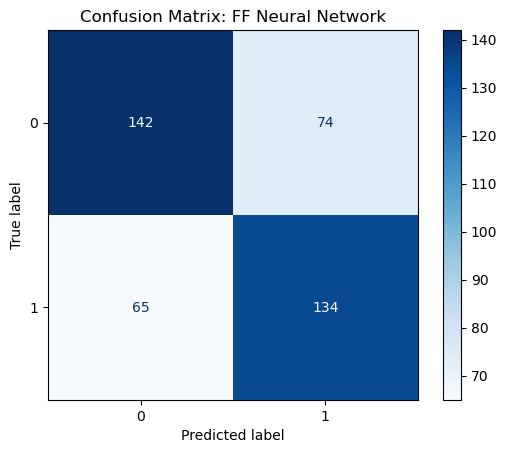

In [7]:
# feedforward neural network
print("\nTraining FF Neural Network...")

# define the FFNN model
input_dim = X_train_selected.shape[1]
model = Sequential([
    Dense(16, activation="relu", input_dim=input_dim),
    Dropout(0.5),
    Dense(16, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# train the FFNN model
start_time = time.time()
history = model.fit(
    X_train_selected, y_train,
    validation_data=(X_val_selected, y_val),
    epochs=100,
    batch_size=16,
    verbose=2
)
duration = time.time() - start_time

# plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('FFNN Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# evaluate FFNN model
y_pred_train = (model.predict(X_train_selected) > 0.5).astype(int)
y_pred_val = (model.predict(X_val_selected) > 0.5).astype(int)
y_prob_val = model.predict(X_val_selected)

train_f1 = f1_score(y_train, y_pred_train, average="weighted")
val_f1 = f1_score(y_val, y_pred_val, average="weighted")

roc_auc_fnn = roc_auc_score(y_val, y_prob_val)  # Use probabilities directly
print(f"\nTraining Accuracy: {accuracy_score(y_train, y_pred_train)}")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_val)}")
print(f"ROC AUC (OvR): {roc_auc_fnn}\n")
print(classification_report(y_val, y_pred_val))

# record FFNN results
summary_results.append({
    "Model": "FF Neural Network",
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Val Accuracy": accuracy_score(y_val, y_pred_val),
    "Train F1": train_f1,
    "Val F1": val_f1,
    "ROC AUC": roc_auc_fnn,
    "Train Time (s)": duration,
})

# confusion matrix for FFNN
cm_fnn = confusion_matrix(y_val, y_pred_val)
disp_fnn = ConfusionMatrixDisplay(confusion_matrix=cm_fnn, display_labels=classes)
disp_fnn.plot(cmap="Blues")
plt.title("Confusion Matrix: FF Neural Network")
plt.show()

In [8]:
# display summary results
summary_df = pd.DataFrame(summary_results)
print("\nBinary, Age 8+\nSummary Results:")
print(summary_df)


Binary, Age 8+
Summary Results:
                 Model  Train Accuracy  Val Accuracy  Train F1    Val F1  \
0    Majority Baseline        0.504815      0.520482  0.356336  0.356336   
1  Logistic Regression        0.668539      0.667470  0.668254  0.667570   
2        Random Forest        0.753612      0.660241  0.753582  0.660324   
3    Gradient Boosting        0.844302      0.643373  0.844286  0.643481   
4    FF Neural Network        0.701445      0.665060  0.701278  0.665200   

    ROC AUC  Train Time (s)  
0  0.500000        0.000000  
1  0.714429        0.931822  
2  0.704564        1.797584  
3  0.697620        3.505817  
4  0.724456       65.308713  
